# Project 4: Home Sales Price Predictive Model
- Fall 2019 w207 Section 5
- Tina Huang, Bona Lee, Miroslava Walekova

## 1. Introduction
The purpose of this project is to build a regression model that predicts sales price of a house.
The original problem statement along with the dataset can be found in this [link](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
## 2. Data Extraction
As an initial step, we extract raw data from the link above and perform basic analysis on the data to grasp a general understanding of the dataset we will be working with.

In [1]:
# Import all libraries that we will be using in our analysis
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Libraries for preprocessing
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Library for feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Libraries for regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

# Libraries for automation
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# SK-learn libraries for model evaluation
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import mean_squared_log_error

# Libraries for ensemble model
from sklearn.ensemble import VotingRegressor
#from sklearn.ensemble import StackingRegressor

# Hide all warning messages
import warnings
warnings.filterwarnings('ignore')

We have 1,460 observations in our raw training dataset and 1,459 observations in our raw test dataset with 80 features.

In [2]:
train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
train_data = train.drop(['SalePrice'], axis=1)
train_labels = train[['SalePrice']]
test_data = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

print('training data shape:', train_data.shape)
print('test data shape:', test_data.shape)

training data shape: (1460, 80)
test data shape: (1459, 80)


In [3]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Out of 80 features, 37 of them are numerical variables, and 43 of them are categorical variables.

In [5]:
print("Numerical variables = %i" % len(train_data.select_dtypes(include=['int64', 'float64']).columns))
print("Categorical variables = %i" % len(train_data.select_dtypes(include=['object']).columns))

Numerical variables = 37
Categorical variables = 43


## 3. Data Cleansing
In this step, we detect and handle all null values and erroneous data points.

In [6]:
# Create a function that computes statistics on null values in a given dataset
def get_null_value_ratio(data):
    total_count = len(data)
    null_value_ratio = data.isnull().sum()/total_count*100
    
    # Convert Pandas Series to DataFrame
    null_value_ratio = pd.DataFrame({'Null Value Ratio': null_value_ratio})
    
    # Drop all columns without any null values &
    # sort the dataframe from highest null value ratio to lowest null value
    null_value_ratio = null_value_ratio[null_value_ratio['Null Value Ratio']>0] \
                       .sort_values(by='Null Value Ratio', ascending=False)
    
    return null_value_ratio

In our training dataset, there are 19 columns that have missing data points, and in our test dataset, there are 33 columns that have missing data points.

In [7]:
train_data_null_values = get_null_value_ratio(train_data)
test_data_null_values = get_null_value_ratio(test_data)

print("***** Null value ratio BEFORE handling null values *****")
print("[TRAIN] Number of columns with null values = %i" % len(train_data_null_values))
print("[TEST] Number of columns with null values = %i" % len(test_data_null_values))

***** Null value ratio BEFORE handling null values *****
[TRAIN] Number of columns with null values = 19
[TEST] Number of columns with null values = 33


In [8]:
train_data_null_values

,Null Value Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945
GarageQual,5.547945


In [9]:
test_data_null_values

,Null Value Ratio
PoolQC,99.794380
MiscFeature,96.504455
Alley,92.666210
Fence,80.123372
FireplaceQu,50.034270
LotFrontage,15.558602
GarageCond,5.346127
GarageYrBlt,5.346127
GarageQual,5.346127
GarageFinish,5.346127


In [10]:
train_data[train_data["Electrical"].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal


After going through the data description of all columns with null values in our training dataset, we concluded that it is sensical that all null values are assigned either 'None' or 0 except for 'Electrical' column, which we will remove from our dataset as there is only one row that has missing data; therefore, it does not have a significant impact on our analysis.

In [11]:
# Delete the corresponding row in train_labels prior to delete the row in train_data
train_labels = train_labels[train_data["Electrical"].isnull()==False]

train_data = train_data[train_data["Electrical"].isnull()==False]
train_data.shape

(1459, 80)

For our test dataset, since we cannot remove any observations from the dataset, we will fill the null values of the following columns(those that cannot have 'None' or 0 as values) with most frequently appeared values.
- MSZoning: 'RL'
- Functional: 'Typ'
- Utilities: 'AllPub'
- SaleType: 'WD'

In [12]:
print("Most frequent values:")
print('- MSZoning: %s' % test_data['MSZoning'].value_counts().idxmax())
print('- Functional: %s' % test_data['Functional'].value_counts().idxmax())
print('- Utilities: %s' % test_data['Utilities'].value_counts().idxmax())
print('- SaleType: %s' % test_data['SaleType'].value_counts().idxmax())

Most frequent values:
- MSZoning: RL
- Functional: Typ
- Utilities: AllPub
- SaleType: WD


In [13]:
test_data['MSZoning'] = test_data['MSZoning'].fillna(test_data['MSZoning'].value_counts().idxmax())
test_data['Functional'] = test_data['Functional'].fillna(test_data['Functional'].value_counts().idxmax())
test_data['Utilities'] = test_data['Utilities'].fillna(test_data['Utilities'].value_counts().idxmax())
test_data['SaleType'] = test_data['SaleType'].fillna(test_data['SaleType'].value_counts().idxmax())

In [14]:
# Create a function that handles missing values in a given dataset
# 1) For categorical variables, fill null values with 'None'
# 2) For numerical variables, fill null values with 0
def update_null_values(data):
    column_names = data.columns
    data_types = data.dtypes
    
    for i in range(len(column_names)):
        
        data_type = data_types[i]
        
        if data_type in ['int64', 'float64']:
            data[column_names[i]] = data[column_names[i]].fillna(0)
            
        elif data_type in ['object']:
            data[column_names[i]] = data[column_names[i]].fillna('None')
    
    return data

In [15]:
train_data = update_null_values(train_data)
test_data = update_null_values(test_data)

train_data_null_values = get_null_value_ratio(train_data)
test_data_null_values = get_null_value_ratio(test_data)

print("***** Null value ratio AFTER handling null values *****")
print("[TRAIN] Number of columns with null values = %i" % len(train_data_null_values))
print("[TEST] Number of columns with null values = %i" % len(test_data_null_values))

***** Null value ratio AFTER handling null values *****
[TRAIN] Number of columns with null values = 0
[TEST] Number of columns with null values = 0


In the following code, we check to see if there is any column with a constant value, which does not add any value to the target variable ('SalePrice') prediction.

In [16]:
for col in train_data.columns:
    unique_value_count = len(train_data[col].unique())
    
    if unique_value_count==1:
        print('%s: %s' % (col, train_data[col].unique()))

As you can see above, there is no column with a constant value; therefore, we do not need to remove any columns.

In the following code, we graph boxplots for all numerical variables in order to detect any erroneous data points and/or outliers. We did not detect any outstanding erroneous data points in our training dataset, and although we were able to spot some outliers, we did not handle those values.

In [17]:
train_data_numerical = train_data.select_dtypes(include=['int64', 'float64'])
train_data_categorical = train_data.select_dtypes(include=['object'])

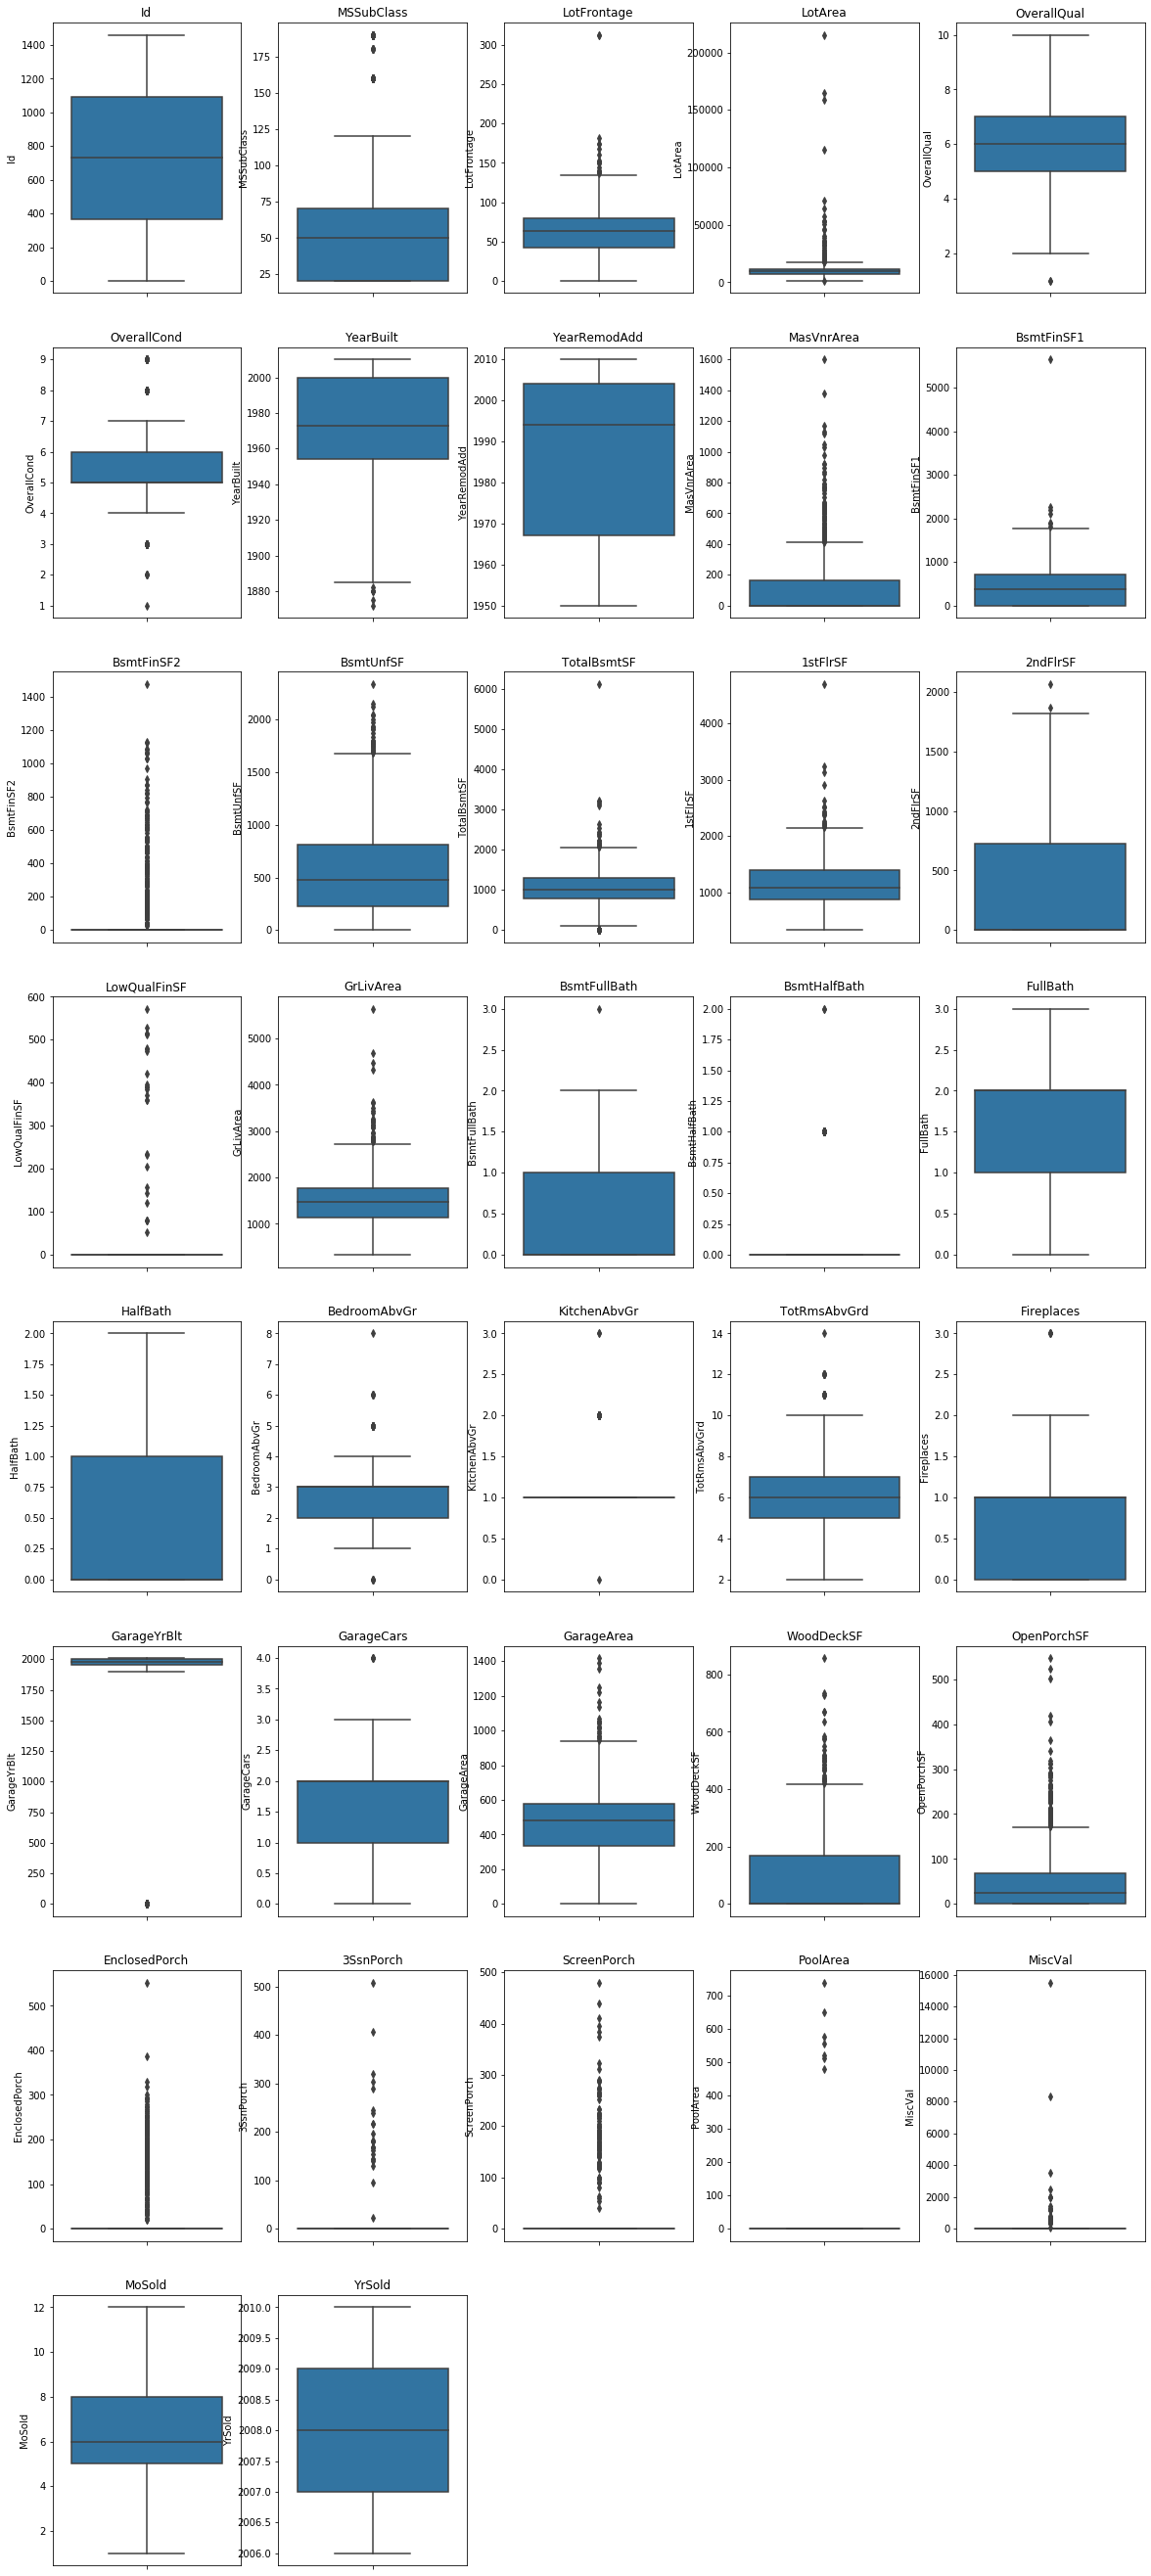

In [18]:
fig, ax = plt.subplots(ncols = 5, figsize = (20,60))
r = 1
for col in train_data_numerical.columns:
    plt.subplot(10,5,r)
    sns.boxplot(y = col, data = train_data_numerical)
    plt.title(col)
    r += 1

## 4. Exploratory Data Analysis
In this step, we look at distribution of each variable as well as correlation/relationship between the variables to determine whether or not data transformation is required.

In [19]:
train = pd.concat([train_data, train_labels], sort=False, axis=1)
train.shape

(1459, 81)

After looking through the distribution plots of all variables and the boxplots of all variables in relation to the target variable 'SalePrice', which can be found in the Appendix, we identified 'Utilities' feature is extremely skewed where all observations have 'AllPub' as a value except for one observation with 'NoSeWa' as shown below. We will remove this feature in the next step - data transformation - accordingly as it does not add any value in predicting the target variable.

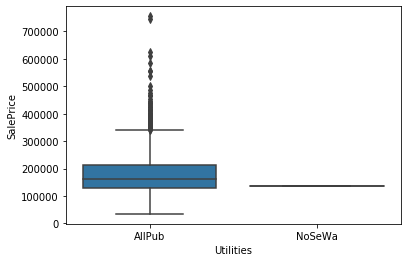

In [20]:
sns.boxplot(y = 'SalePrice', x = 'Utilities', data = train)

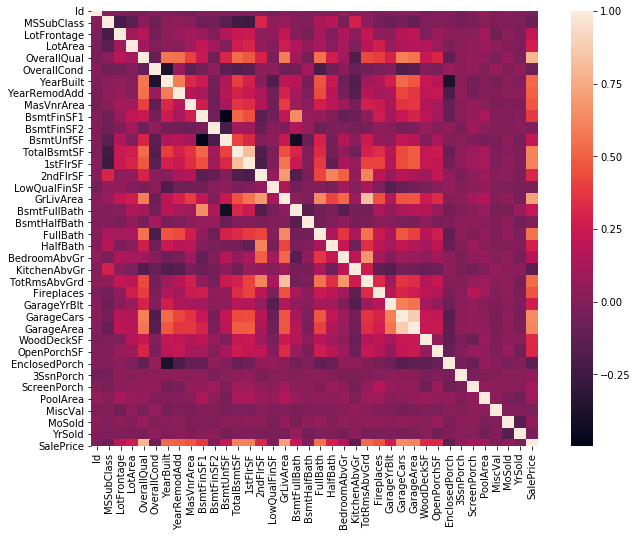

In [21]:
cor = train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(cor, square=True)

Based on the correlation plot above, we were able to identify that 'SalePrice' and 'OverallQual' have the strongest correlation, which was confirmed by the graph below.

As expected, as overall quality of a house increases, house sales price increases as well.

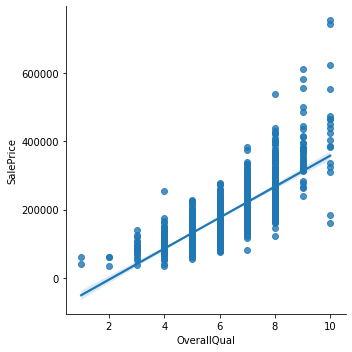

In [22]:
g = sns.lmplot(x="OverallQual", y="SalePrice", truncate=True, data=train)
g.set_axis_labels("OverallQual","SalePrice")

## 5. Data Transformation
In this step, we transform our dataset based on the findings from the Exploratory Data Analysis.

### 5-1. Feature Transformation

In [23]:
# Ordinal features
ordinal_variables1 = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual',
                      'FireplaceQu','GarageQual','GarageCond','PoolQC']
ordinal_variables2 = ['BsmtExposure']
ordinal_variables3 = ['BsmtFinType1','BsmtFinType2']
ordinal_variables4 = ['Fence']

# Binary features
binary_variables = ['CentralAir']

def returnOrdinalVariable1(row, col):
    value = 0
    if (row[col] == 'Ex'):
        value = 5
    elif (row[col] == 'Gd'):
        value = 4
    elif (row[col] == 'TA'):
        value = 3
    elif (row[col] == 'Fa'):
        value = 2
    elif (row[col] == 'Po'):
        value = 1
    else:
        value = 0
    return value

def returnOrdinalVariable2(row, col):
    value = 0
    if (row[col] == 'Gd'):
        value = 4
    elif (row[col] == 'Av'):
        value = 3
    elif (row[col] == 'Mn'):
        value = 2
    elif (row[col] == 'No'):
        value = 1
    else:
        value = 0
    return value

def returnOrdinalVariable3(row, col):
    value = 0
    if (row[col] == 'GLQ'):
        value = 6
    elif (row[col] == 'ALQ'):
        value = 5
    elif (row[col] == 'BLQ'):
        value = 4
    elif (row[col] == 'Rec'):
        value = 3
    elif (row[col] == 'LwQ'):
        value = 2
    elif (row[col] == 'Unf'):
        value = 1
    else:
        value = 0
    return value

def returnOrdinalVariable4(row, col):
    value = 0
    if (row[col] == 'GdPrv'):
        value = 4
    elif (row[col] == 'MnPrv'):
        value = 3
    elif (row[col] == 'GdWo'):
        value = 2
    elif (row[col] == 'MnWw'):
        value = 1
    else:
        value = 0
    return value

def convertOrdinalVariables(data):
    columns = data.columns
    for i in range(len(columns)):
        if columns[i] in ordinal_variables1:
            data[columns[i]] = data.apply(lambda x: returnOrdinalVariable1(x, columns[i]), axis=1)
        elif columns[i] in ordinal_variables2:
            data[columns[i]] = data.apply(lambda x: returnOrdinalVariable2(x, columns[i]), axis=1)
        elif columns[i] in ordinal_variables3:
            data[columns[i]] = data.apply(lambda x: returnOrdinalVariable3(x, columns[i]), axis=1)
        elif columns[i] in ordinal_variables4:
            data[columns[i]] = data.apply(lambda x: returnOrdinalVariable4(x, columns[i]), axis=1)
    return data

We converted categorical ordinal variables into numerical ordinal variables based on the corresponding ranking. 

We also converted categorical binary variables into numerical binary variables (0,1) prior to converting all categorical variables into dummy variables to prevent the transformation function from making too many dummy variables.

In [24]:
def transformData(data):
    # Drop ID column since it's a key field
    data = data.drop(['Id'], axis = 1)
    
    # Drop 'Utilities' column since there is only one row that is different from all other rows,
    # and there is no difference in the target variable
    data = data.drop(['Utilities'], axis = 1)
    
    # Ordinal variable conversion
    data = convertOrdinalVariables(data)
    
    # Binary variable conversion
    data['CentralAir'] = data.apply(lambda row: 1 if row.CentralAir=='Y' else 0, axis=1)
    
    # Convert the remaining categorical variables into dummy variables
    data_transformed = pd.get_dummies(data)
    
    return data_transformed

In [25]:
# Baseline data
train_data_transformed = transformData(train_data)
test_data_transformed = transformData(test_data)

# Align Dummy variables
train_col = train_data_transformed.columns
test_col = test_data_transformed.columns
for col in train_col:
    if (col not in test_col):
        test_data_transformed[col] = 0

for col in test_col:
    if (col not in train_col):
        train_data_transformed[col] = 0

print('training data shape:', train_data_transformed.shape)
print('test data shape:',  test_data_transformed.shape)

training data shape: (1459, 241)
test data shape: (1459, 241)


In [26]:
train_data_transformed.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Exterior1st_None,Exterior2nd_None
0,60,65.0,8450,7,5,2003,2003,196.0,4,3,...,0,1,0,0,0,0,1,0,0,0
1,20,80.0,9600,6,8,1976,1976,0.0,3,3,...,0,1,0,0,0,0,1,0,0,0
2,60,68.0,11250,7,5,2001,2002,162.0,4,3,...,0,1,0,0,0,0,1,0,0,0
3,70,60.0,9550,7,5,1915,1970,0.0,3,3,...,0,1,1,0,0,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,4,3,...,0,1,0,0,0,0,1,0,0,0


In [27]:
test_data_transformed.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,Exterior1st_ImStucc,Exterior1st_Stone,Exterior2nd_Other,Heating_Floor,Heating_OthW,Electrical_Mix,MiscFeature_TenC
0,20,80.0,11622,5,6,1961,1961,0.0,3,3,...,0,0,0,0,0,0,0,0,0,0
1,20,81.0,14267,6,6,1958,1958,108.0,3,3,...,0,0,0,0,0,0,0,0,0,0
2,60,74.0,13830,5,5,1997,1998,0.0,3,3,...,0,0,0,0,0,0,0,0,0,0
3,60,78.0,9978,6,6,1998,1998,20.0,3,3,...,0,0,0,0,0,0,0,0,0,0
4,120,43.0,5005,8,5,1992,1992,0.0,4,3,...,0,0,0,0,0,0,0,0,0,0


### 5-2. Target Variable Transformation

We will use log-transformed values for our target variable 'SalePrice' as it's more normally distributed.

,SalePrice
count,1459.000000
mean,180930.394791
std,79468.964025
min,34900.000000
25%,129950.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


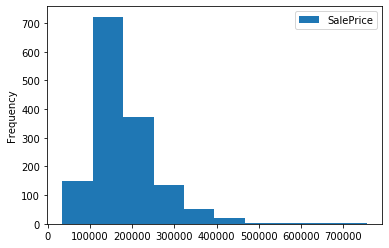

In [28]:
train_labels.plot.hist()
train_labels.describe()

count    1459.000000
mean       12.024048
std         0.399589
min        10.460242
25%        11.774905
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

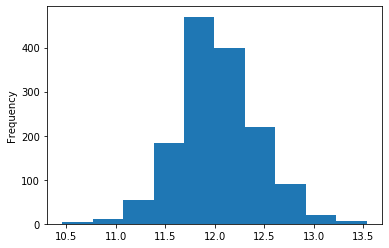

In [29]:
np.log(train_labels['SalePrice']).plot.hist()
np.log(train_labels['SalePrice']).describe()

## 6. Regression Model

### 6-1. Baseline
After data transformation, baseline models are built using the following regression algorithms:
- Linear regression
- Lasso
- Random Forest
- Ridge

In [30]:
# Split training dataset into train and dev so that we can fit the model
# based on the train dataset but evaluate the model based on the dev dataset which will be unseen throughout the training with cross-validation
X_train, X_dev, y_train, y_dev = train_test_split(train_data_transformed, train_labels, test_size=0.3, random_state=100)

In [31]:
# Linear regression model
lr = LinearRegression()
lr.fit(X_train, np.log(y_train))
print("Baseline:")
print('[Linear regression] Score = %3.4f' % lr.score(X_dev, np.log(y_dev)))

# Lasso model
lasso = Lasso()
lasso.fit(X_train, np.log(y_train))
print('[Lasso] Score = %3.4f' % lasso.score(X_dev, np.log(y_dev)))

# Random Forest model
rf = RandomForestRegressor()
rf.fit(X_train, np.log(y_train))
print('[Random Forest] Score = %3.4f' % rf.score(X_dev, np.log(y_dev)))

# Ridge model
ridge = Ridge()
ridge.fit(X_train, np.log(y_train))
print('[Ridge] Score = %3.4f' % ridge.score(X_dev, np.log(y_dev)))

Baseline:
[Linear regression] Score = 0.7550
[Lasso] Score = 0.7695
[Random Forest] Score = 0.8462
[Ridge] Score = 0.8207


In [32]:
# Create a function that computes various metrics on model performance
def print_accuracy_report(model, X, y, num_validations=5):
    
    explained_variance = cross_val_score(model, X, y, scoring='explained_variance', cv=num_validations)
    print("explained_variance: " + str(round(100*explained_variance.mean(), 2)))

    r2 = cross_val_score(model, X, y, scoring='r2', cv=num_validations)
    print("r2: " + str(round(100*r2.mean(), 2)))
    
    neg_mean_absolute_error = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=num_validations)
    print("neg_mean_absolute_error: " + str(round(100*neg_mean_absolute_error.mean(), 2)))
    
    neg_mean_squared_error = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=num_validations)
    print("neg_mean_squared_error: " + str(round(100*neg_mean_squared_error.mean(), 2)))
    
    scores = np.sqrt(-1 * cross_val_score(model, X, y, cv=num_validations, scoring='neg_mean_squared_log_error'))
    print(f"RMSLE scores mean: {scores.mean():,.5f}")
    print(f"RMSLE scores std: {scores.std():,.5f}")
    full_score = np.sqrt(mean_squared_log_error(y, model.predict(X)))
    print(f"Full MSLE: {full_score:,.5f}")

In [33]:
print('*** LINEAR REGRESSION ***')
print_accuracy_report(lr, X_dev, np.log(y_dev))

print('*** LASSO ***')
print_accuracy_report(lasso, X_dev, np.log(y_dev))

print('*** RANDOM FOREST ***')
print_accuracy_report(rf, X_dev, np.log(y_dev))

print('*** RIDGE ***')
print_accuracy_report(ridge, X_dev, np.log(y_dev))

*** LINEAR REGRESSION ***
explained_variance: 71.26
r2: 70.68
neg_mean_absolute_error: -12.34
neg_mean_squared_error: -4.46
RMSLE scores mean: 0.01632
RMSLE scores std: 0.00406
Full MSLE: 0.01423
*** LASSO ***
explained_variance: 78.69
r2: 78.35
neg_mean_absolute_error: -12.8
neg_mean_squared_error: -3.31
RMSLE scores mean: 0.01389
RMSLE scores std: 0.00252
Full MSLE: 0.01449
*** RANDOM FOREST ***
explained_variance: 80.59
r2: 81.18
neg_mean_absolute_error: -11.99
neg_mean_squared_error: -2.94
RMSLE scores mean: 0.01319
RMSLE scores std: 0.00247
Full MSLE: 0.01188
*** RIDGE ***
explained_variance: 84.89
r2: 84.37
neg_mean_absolute_error: -10.57
neg_mean_squared_error: -2.43
RMSLE scores mean: 0.01196
RMSLE scores std: 0.00256
Full MSLE: 0.01293


### 6-2. Model Pipeline and GridSearch
We used pipeline to find the optimal set of hyperparameters that produces the best model for each regression model.

In [34]:
# Linear regression model pipeline
scalers_to_test = [StandardScaler(), RobustScaler(), QuantileTransformer()]
n_features_to_test = [10,30,50,70,90,95,100,110,120,130]

parameteres = [
        {'scaler': scalers_to_test,
         'reduce_dim': [PCA()],
         'reduce_dim__n_components': n_features_to_test}
        ]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reduce_dim', PCA()),
    ('regressor', LinearRegression())
])

grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid.fit(X_train, np.log(y_train))

lr_best = grid.best_estimator_
lr_best_params = grid.best_params_
print(lr_best_params)
print("Testing score: %3.4f" % grid.score(X_dev, np.log(y_dev)))

{'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 100, 'scaler': QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)}
Testing score: 0.8751


In [35]:
# Lasso regression model pipeline
scalers_to_test = [StandardScaler(), RobustScaler(), QuantileTransformer()]
n_features_to_test = [50,150,200]
alpha_to_test = [0.0007, 0.0005, 0.0001]
tol_to_test = [0.000005, 0.00001, 0.00005, 0.0001]

parameteres = [
        {'scaler': scalers_to_test,
         'reduce_dim': [PCA()],
         'reduce_dim__n_components': n_features_to_test,
         'regressor__alpha': alpha_to_test,
         'regressor__tol': tol_to_test}
        ]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reduce_dim', PCA()),
    ('regressor', Lasso())
])

grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid.fit(X_train, np.log(y_train))

lasso_best = grid.best_estimator_
lasso_best_params = grid.best_params_
print(lasso_best_params)
print("[Lasso] Testing score: %3.4f" % grid.score(X_dev, np.log(y_dev)))

{'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 200, 'regressor__alpha': 0.0005, 'regressor__tol': 5e-06, 'scaler': QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)}
[Lasso] Testing score: 0.8815


We used RandomizedSearchCV instead of GridSearchCV for Random Forest mainly due to performance issues.

In [36]:
# Random forest regression model pipeline
#n_features_to_test = [50,100,200]
n_estimators_to_test = [int(x) for x in np.linspace(start = 1000, stop = 2000, num = 100)] # Number of trees in random forest
max_features_to_test = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth_to_test = [int(x) for x in np.linspace(40, 60, num = 10)] # Maximum number of levels in tree
min_samples_split_to_test = [2, 5, 7] # Minimum number of samples required to split a node
min_samples_leaf_to_test = [1, 3, 4, 5] # Minimum number of samples required at each leaf node
bootstrap_to_test = [False] # Method of selecting samples for training each tree

parameteres = {
         #'reduce_dim': [PCA()],
         #'reduce_dim__n_components': n_features_to_test,
         'regressor__n_estimators': n_estimators_to_test,
         'regressor__max_features': max_features_to_test,
         'regressor__max_depth': max_depth_to_test,
         'regressor__min_samples_split': min_samples_split_to_test,
         'regressor__min_samples_leaf': min_samples_leaf_to_test,
         'regressor__bootstrap': bootstrap_to_test
        }

pipeline = Pipeline([
    #('reduce_dim', PCA()),
    ('regressor', RandomForestRegressor())
])
"""
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
"""
grid = RandomizedSearchCV(pipeline, param_distributions=parameteres, cv=5)
grid.fit(X_train, np.log(y_train))

rf_best = grid.best_estimator_
rf_best_params = grid.best_params_
print(rf_best_params)
print("[Random Forest] Testing score: %3.4f" % grid.score(X_dev, np.log(y_dev)))

{'regressor__n_estimators': 1525, 'regressor__min_samples_split': 7, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 60, 'regressor__bootstrap': False}
[Random Forest] Testing score: 0.8533


In [37]:
# Ridge regression model pipeline
scalers_to_test = [StandardScaler(), RobustScaler(), QuantileTransformer()]
n_features_to_test = [100,150,200]
alpha_to_test = [1, 5, 7, 9]
tol_to_test = [0.000005, 0.00001, 0.00005, 0.0001]

parameteres = [
        {'scaler': scalers_to_test,
         'reduce_dim': [PCA()],
         'reduce_dim__n_components': n_features_to_test,
         'regressor__alpha': alpha_to_test,
         'regressor__tol': tol_to_test}
        ]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reduce_dim', PCA()),
    ('regressor', Ridge())
])

grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid.fit(X_train, np.log(y_train))

ridge_best = grid.best_estimator_
ridge_best_params = grid.best_params_
print(ridge_best_params)
print("[Ridge] Testing score: %3.4f" % grid.score(X_dev, np.log(y_dev)))

{'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 200, 'regressor__alpha': 7, 'regressor__tol': 5e-06, 'scaler': QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)}
[Ridge] Testing score: 0.8845


In [38]:
print('*** LINEAR REGRESSION ***')
print_accuracy_report(lr_best, X_dev, np.log(y_dev))

print('*** LASSO ***')
print_accuracy_report(lasso_best, X_dev, np.log(y_dev))

print('*** RANDOM FOREST ***')
print_accuracy_report(rf_best, X_dev, np.log(y_dev))

print('*** RIDGE ***')
print_accuracy_report(ridge_best, X_dev, np.log(y_dev))

*** LINEAR REGRESSION ***
explained_variance: 83.67
r2: 82.95
neg_mean_absolute_error: -11.4
neg_mean_squared_error: -2.58
RMSLE scores mean: 0.01241
RMSLE scores std: 0.00213
Full MSLE: 0.01076
*** LASSO ***
explained_variance: 85.17
r2: 84.62
neg_mean_absolute_error: -10.74
neg_mean_squared_error: -2.38
RMSLE scores mean: 0.01181
RMSLE scores std: 0.00262
Full MSLE: 0.01047
*** RANDOM FOREST ***
explained_variance: 83.63
r2: 83.54
neg_mean_absolute_error: -10.66
neg_mean_squared_error: -2.65
RMSLE scores mean: 0.01219
RMSLE scores std: 0.00331
Full MSLE: 0.01163
*** RIDGE ***
explained_variance: 86.25
r2: 85.73
neg_mean_absolute_error: -10.37
neg_mean_squared_error: -2.25
RMSLE scores mean: 0.01140
RMSLE scores std: 0.00282
Full MSLE: 0.01034


### 6-3. Ensemble Model
In this step, we combined all four models from the last part and created an ensemble model, which has the highest score and other metrics.

In [39]:
# Create a dictionary of our models
estimators=[('lr', lr_best), ('lasso', lasso_best), ('rf', rf_best), ('ridge', ridge_best)]

# Create our voting regressor, inputting our models
ensemble = VotingRegressor(estimators)

# Change shape of predicted values
y_train_ensemble=np.array(np.log(y_train)).ravel()
y_dev_ensemble=np.array(np.log(y_dev)).ravel()

# Fit model to training data
ensemble.fit(X_train, y_train_ensemble)

# Test our model on the test data
print('[Ensemble] Testing score: %3.4f' % ensemble.score(X_dev, y_dev_ensemble))
print_accuracy_report(ensemble, X_dev, y_dev_ensemble)

[Ensemble] Testing score: 0.8849
explained_variance: 86.58
r2: 86.1
neg_mean_absolute_error: -10.04
neg_mean_squared_error: -2.18
RMSLE scores mean: 0.01123
RMSLE scores std: 0.00285
Full MSLE: 0.01034


## 7. Prediction
In this step, we use the ensemble model from Step 6 to make predictions on our test dataset.

There is one erroneous data point in the test dataset which has '2207' as a value of 'GarageYrBlt' as shown below.
Here, we will assume that it is a typo and change the value to '2007'.

In [40]:
test_data_transformed['GarageYrBlt'].describe()

count    1459.000000
mean     1871.989719
std       445.786118
min         0.000000
25%      1956.000000
50%      1977.000000
75%      2001.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64

In [41]:
test_data_transformed[test_data_transformed["GarageYrBlt"]>2010].GarageYrBlt

1132    2207.0
Name: GarageYrBlt, dtype: float64

In [42]:
test_data_transformed['GarageYrBlt'] = test_data_transformed.apply(lambda x: 2007 if x.GarageYrBlt==2207 else x.GarageYrBlt, axis=1)

In [43]:
final_model = ensemble

In [44]:
predicted_price = final_model.predict(test_data_transformed)

In the following code, we take the inverse log of our predicted values since our model was trained using log-transformed sales price.

In [45]:
test_data['SalePrice'] = np.array(np.exp(predicted_price)).ravel()
test_data.to_csv('submission_regression.csv', columns=['Id', 'SalePrice'], index=False)

## Appendix
### 1. Exploratory Data Analysis

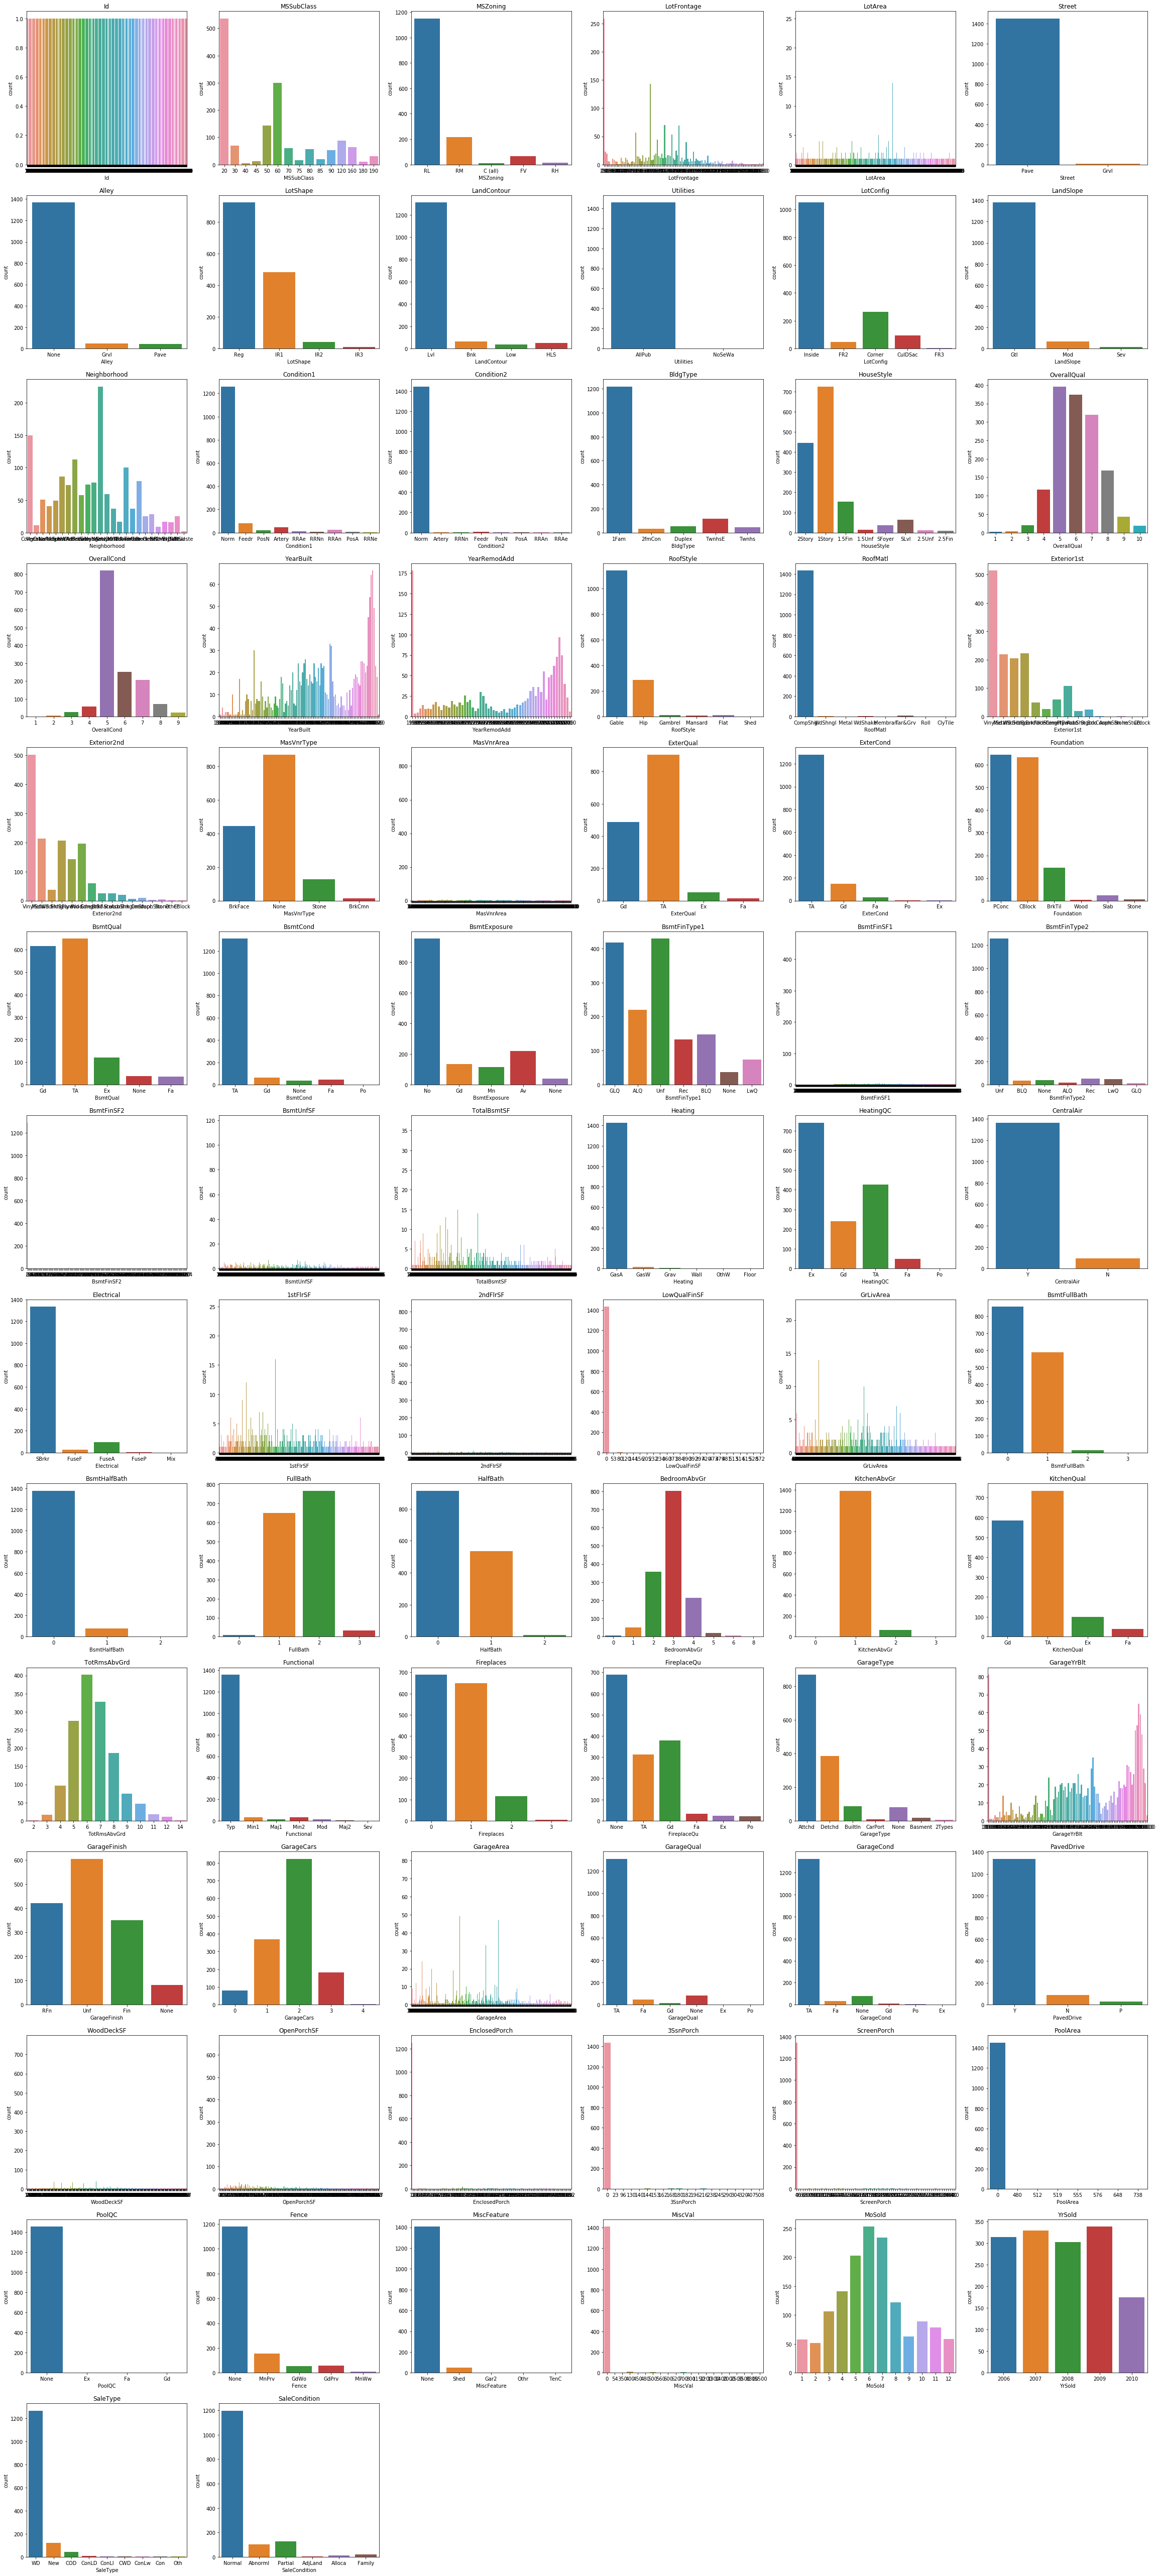

In [46]:
fig, ax = plt.subplots(ncols = 6, figsize = (40,100))
r = 1
for col in train_data.columns:
    plt.subplot(15,6,r)
    sns.countplot(x = col, data = train_data)
    plt.title(col)
    r += 1

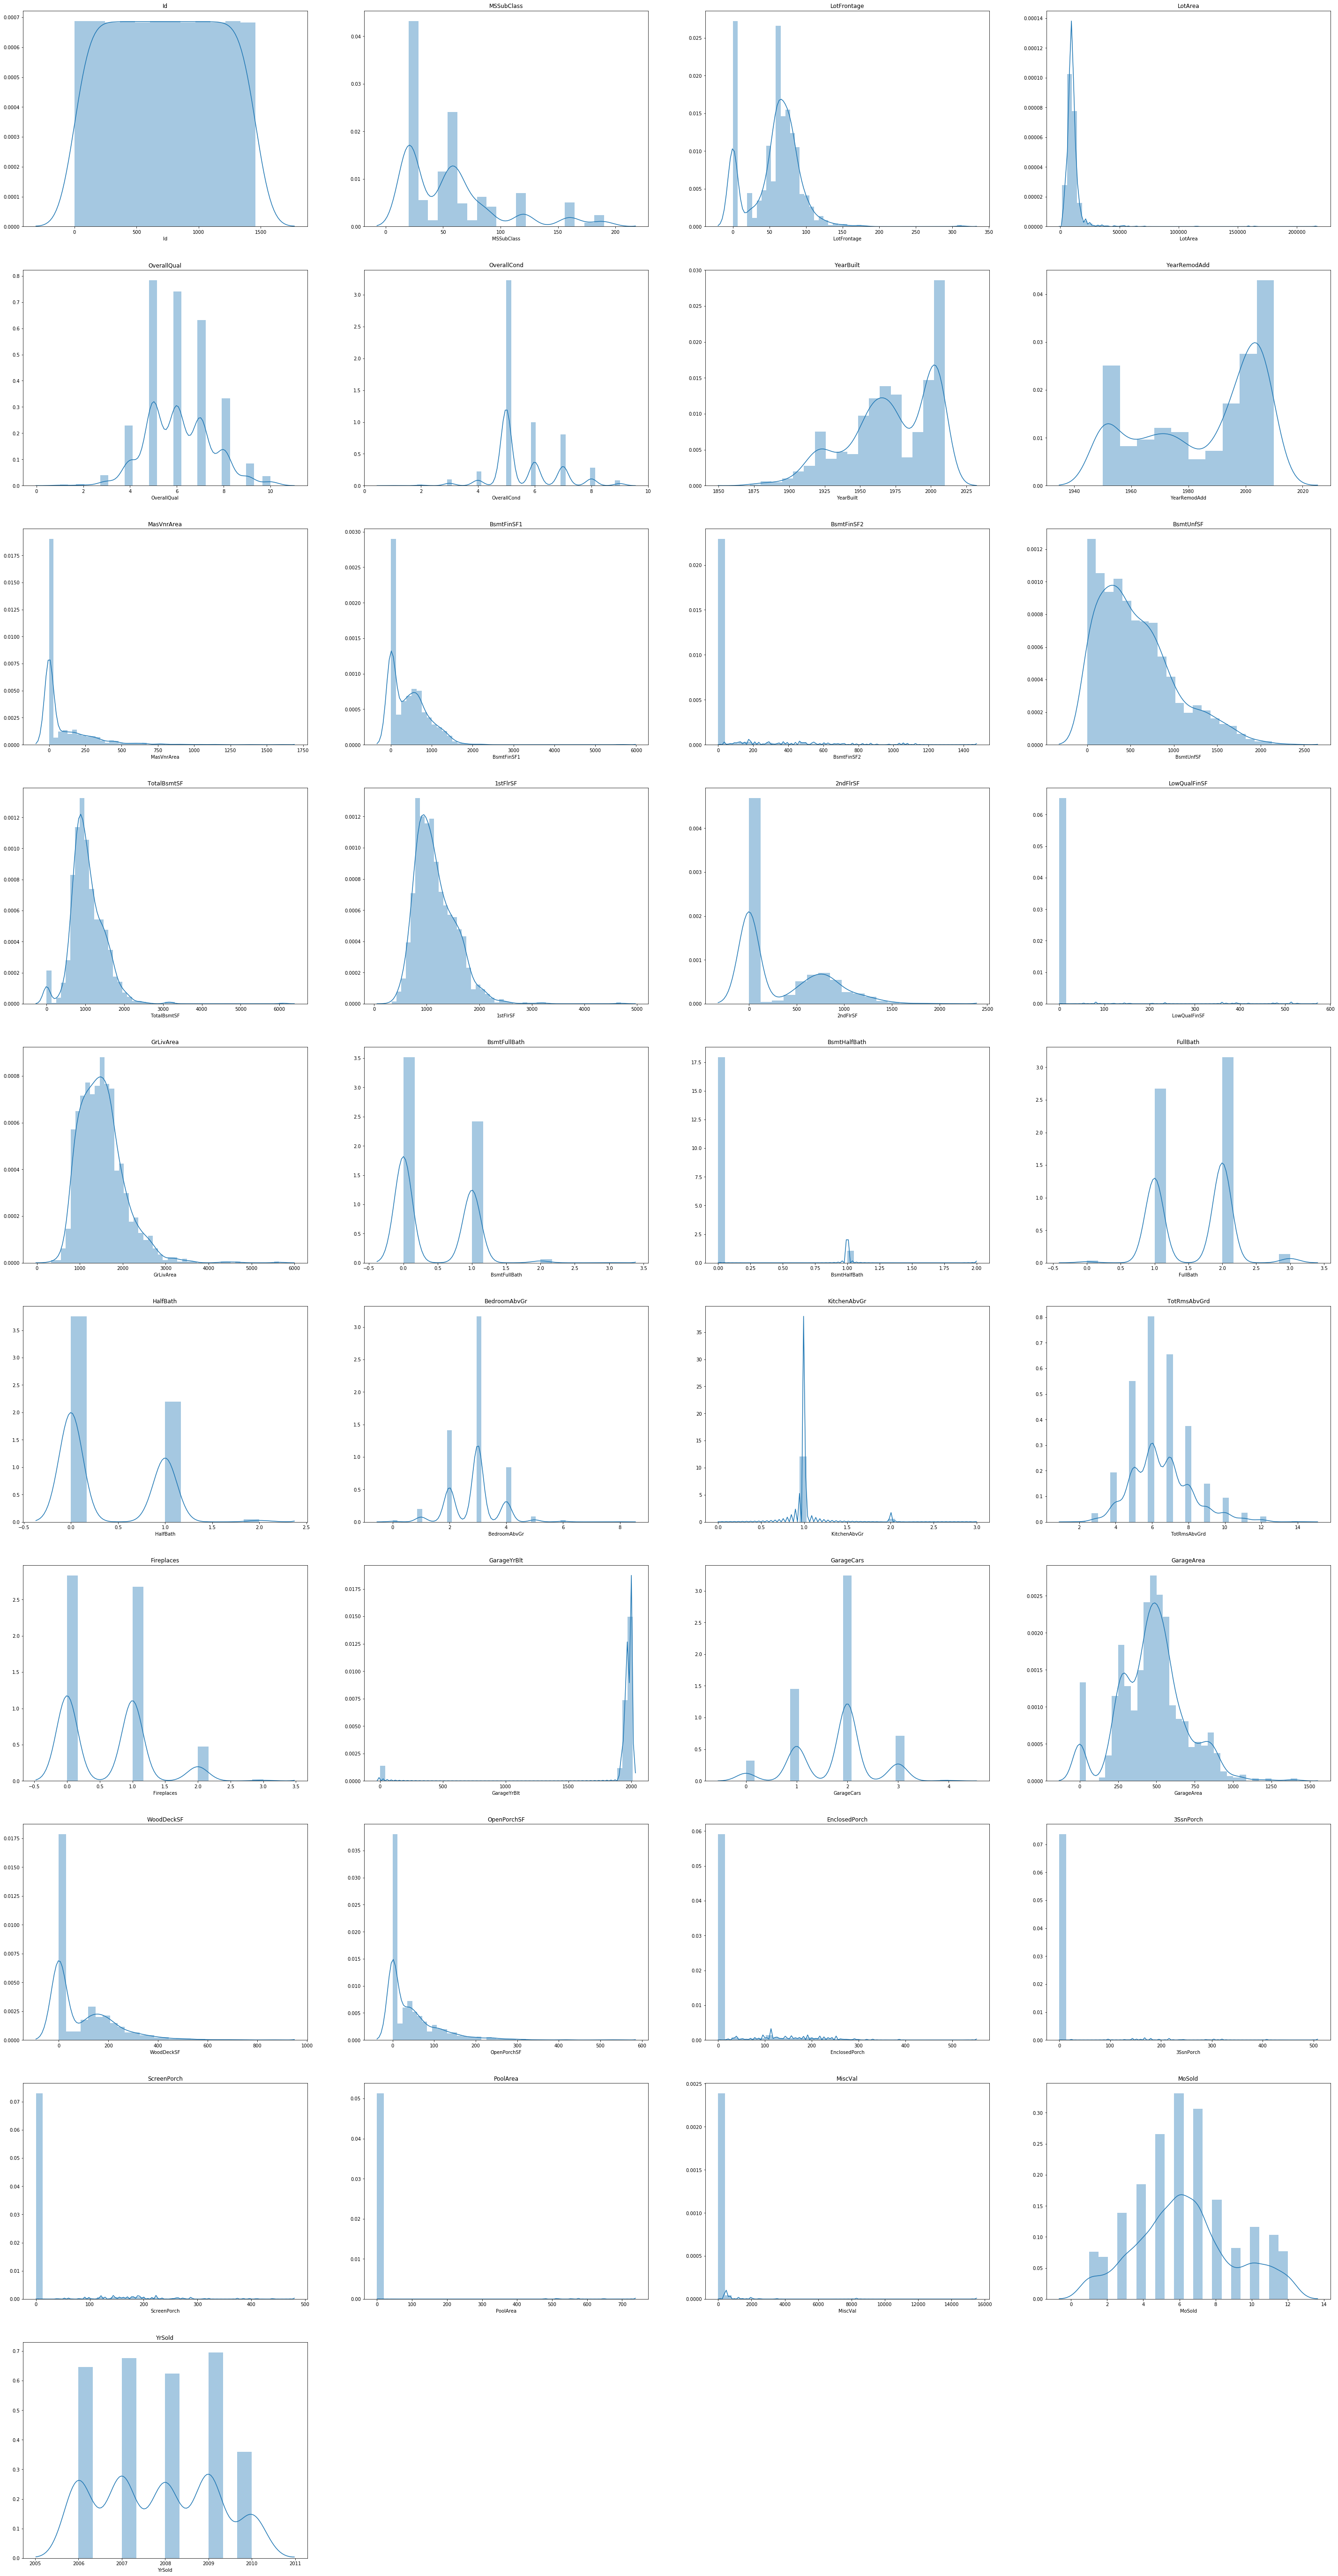

In [47]:
fig, ax = plt.subplots(ncols = 4, figsize = (50,100))
r = 1
for col in train_data_numerical.columns:
    plt.subplot(10,4,r)
    sns.distplot(train_data_numerical[col])
    plt.title(col)
    r += 1

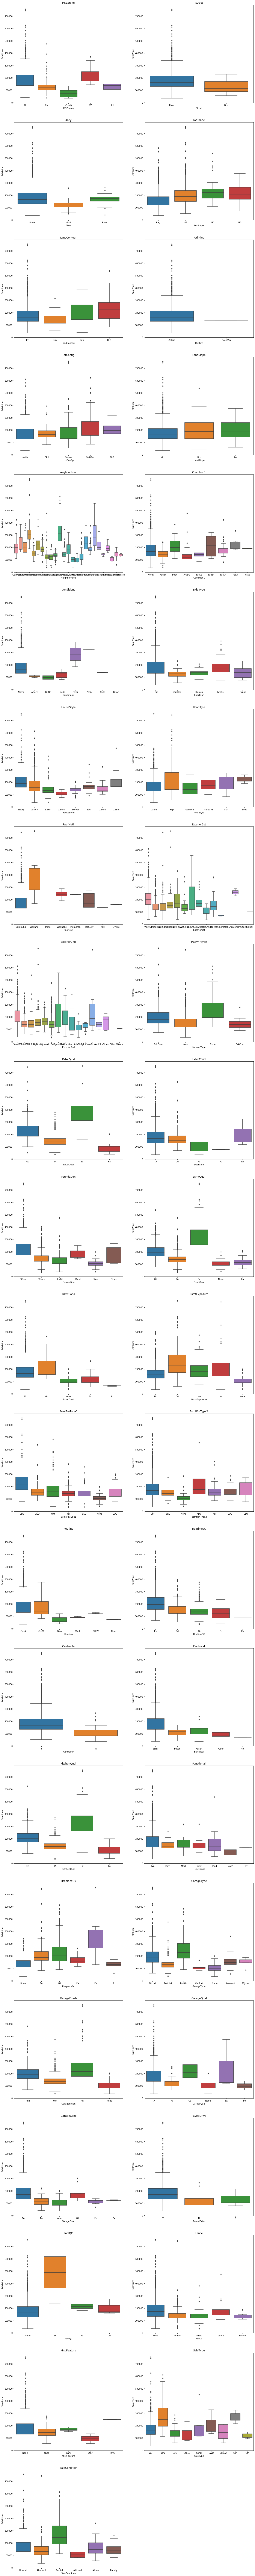

In [48]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,250))
r = 1
for col in train_data_categorical.columns:
    plt.subplot(25,2,r)
    sns.boxplot(y = 'SalePrice', x = col, data = train)
    plt.title(col)
    r += 1

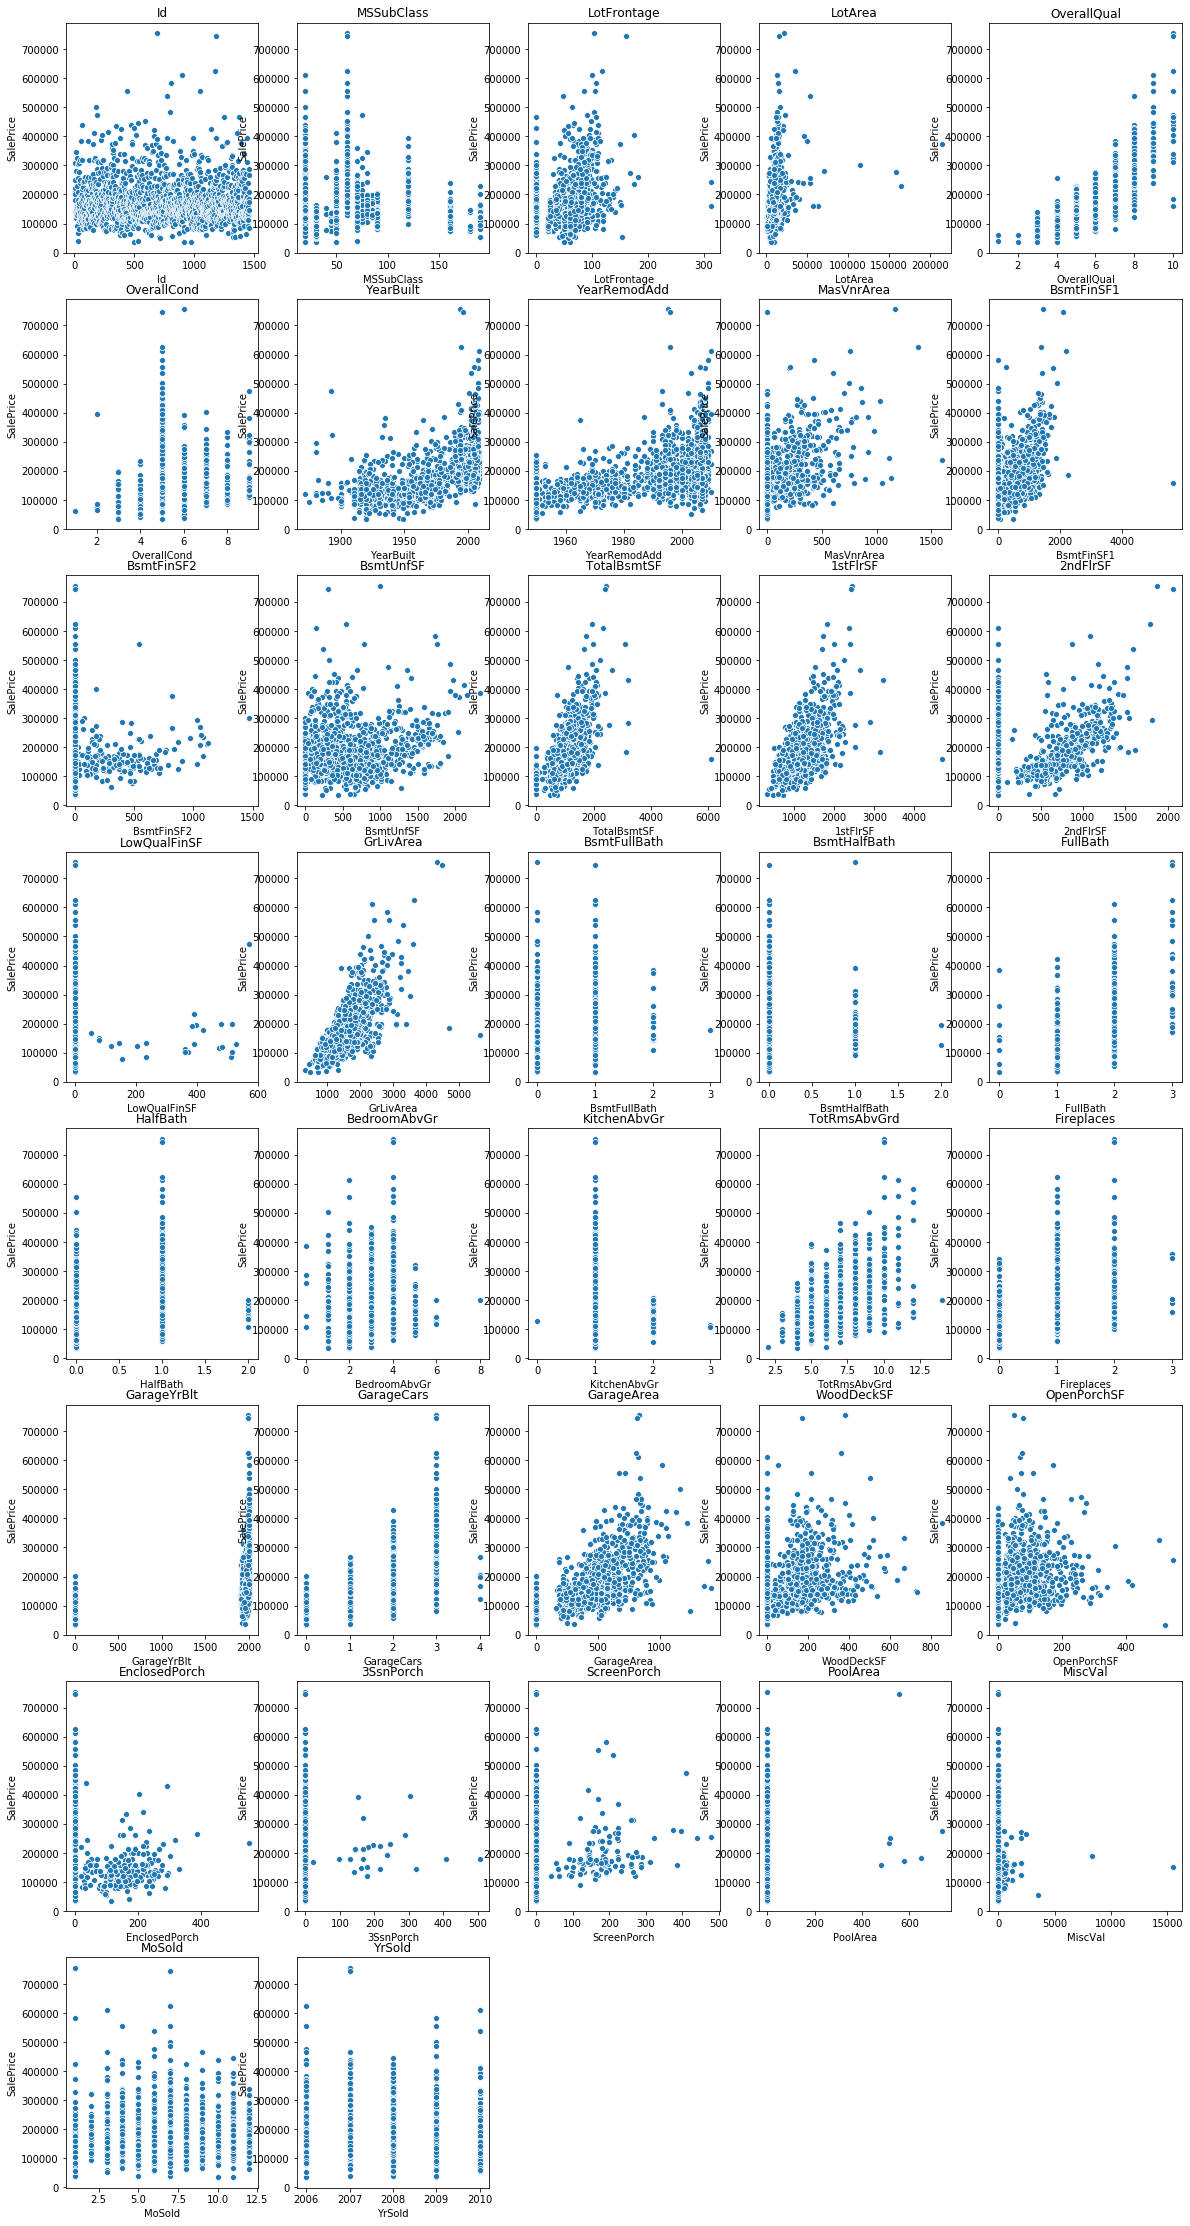

In [49]:
fig, ax = plt.subplots(ncols = 5, figsize = (20,50))
r = 1
for col in train_data_numerical.columns:
    plt.subplot(10,5,r)
    sns.scatterplot(y = 'SalePrice', x = col, data = train)
    plt.title(col)
    r += 1